In [134]:
# importing dependencies
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sms
import numpy as np
import datetime as dt
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [135]:
# read in CSV training data
df_train = pd.read_csv('C:/Users/sweir/OneDrive/Desktop/Analysis Projects/Crude_Oil_Price_Projection/ML Resources/Cleaned_Crude_Oil_Dataset_Train.csv')
df_train

,Date,"Cushing, OK Crude Oil Future Contract ($/Bar.)",U.S. Field Production of Crude Oil (1k Bar.),Product Supplied of Crude Oil and Petroleum Products (1k Bar.),Gross Inputs to Refineries (1k Bar./Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operating Crude Oil Distillation Capacity (1k Bar./Day),Idle Crude Oil Distillation Capacity (1k Bar./Day),Percent Utilization of Refinery Operable Capacity,"Cushing, OK WTI Spot Price FOB ($/Bar.)"
0,1/1/1986,23.0,283248,498728,12583,15459,14639,820,81.4,22.9
1,2/1/1986,15.5,256855,453209,12068,15485,14538,947,77.9,15.5
2,3/1/1986,12.6,279413,504565,11759,15485,14517,968,75.9,12.6
3,4/1/1986,12.8,265917,478339,12603,15473,14550,923,81.5,12.8
4,5/1/1986,15.3,273964,495789,13314,15484,14805,679,86.0,15.4
...,...,...,...,...,...,...,...,...,...,...
339,4/1/2014,102.0,255795,565032,16264,17951,17725,226,90.6,102.1
340,5/1/2014,101.8,267996,576636,16197,17951,17453,498,90.2,102.2
341,6/1/2014,105.1,262288,566345,16087,17825,17579,246,90.3,105.8
342,7/1/2014,102.4,274131,596659,16880,17835,17678,157,94.7,103.6


### Prepping training and testing DataFrames. Data was split 80-20 into training and testing, respectively. Note that the testing data was further split in half in order to help make more accurate projections beyond the original dataset.

In [136]:
# viewing datatypes
df_train.dtypes

Date                                                                object
Cushing, OK Crude Oil Future Contract ($/Bar.)                     float64
U.S. Field Production of Crude Oil (1k Bar.)                         int64
Product Supplied of Crude Oil and Petroleum Products (1k Bar.)       int64
Gross Inputs to Refineries (1k Bar./Day)                             int64
Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)      int64
Operating Crude Oil Distillation Capacity (1k Bar./Day)              int64
Idle Crude Oil Distillation Capacity (1k Bar./Day)                   int64
Percent Utilization of Refinery Operable Capacity                  float64
Cushing, OK WTI Spot Price FOB ($/Bar.)                            float64
dtype: object

In [137]:
# to convert the date column to type DATETIME
df_train['Date'] = pd.to_datetime(df_train['Date'])

In [138]:
# retrieving number of observations
len(df_train)

344

In [139]:
# renaming columns to fit naming conventions of prophet
df_train.rename(columns={'Date': 'ds', 'Cushing, OK Crude Oil Future Contract ($/Bar.)': 'y'}, inplace=True)


In [140]:
# dropping all other columns
df_train.drop(['U.S. Field Production of Crude Oil (1k Bar.)', 'Product Supplied of Crude Oil and Petroleum Products (1k Bar.)', 'Gross Inputs to Refineries (1k Bar./Day)', 'Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)', 'Operating Crude Oil Distillation Capacity (1k Bar./Day)', 'Idle Crude Oil Distillation Capacity (1k Bar./Day)', 'Percent Utilization of Refinery Operable Capacity', 'Cushing, OK WTI Spot Price FOB ($/Bar.)'], axis=1, inplace=True)

In [141]:
# reordering columns to fit prophet requirements
df_train1 = df_train[['y', 'ds']]
df_train1.head()

,y,ds
0,23.0,1986-01-01
1,15.5,1986-02-01
2,12.6,1986-03-01
3,12.8,1986-04-01
4,15.3,1986-05-01


In [144]:
# read in CSV training eval data
df_eval = pd.read_csv('C:/Users/sweir/OneDrive/Desktop/Analysis Projects/Crude_Oil_Price_Projection/ML Resources/Cleaned_Crude_Oil_Dataset_Test1.csv')
df_eval.head()

,Date,"Cushing, OK Crude Oil Future Contract ($/Bar.)",U.S. Field Production of Crude Oil (1k Bar.),Product Supplied of Crude Oil and Petroleum Products (1k Bar.),Gross Inputs to Refineries (1k Bar./Day),Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day),Operating Crude Oil Distillation Capacity (1k Bar./Day),Idle Crude Oil Distillation Capacity (1k Bar./Day),Percent Utilization of Refinery Operable Capacity,"Cushing, OK WTI Spot Price FOB ($/Bar.)"
0,9/1/2014,93.0,272571,576110,16358,17835,17678,157,91.7,93.2
1,10/1/2014,84.3,287193,610719,15660,17851,17466,385,87.7,84.4
2,11/1/2014,75.8,279793,581811,16367,17811,17672,139,91.9,75.8
3,12/1/2014,59.3,296480,604310,16751,17811,17635,177,94.1,59.3
4,1/1/2015,47.3,290856,597459,15767,17967,17768,200,87.8,47.2


In [145]:
# to convert the date column to type DATETIME
df_eval['Date'] = pd.to_datetime(df_eval['Date'])

In [146]:
# renaming columns to fit naming conventions of prophet
df_eval.rename(columns={'Date': 'ds', 'Cushing, OK Crude Oil Future Contract ($/Bar.)': 'y'}, inplace=True)

In [147]:
# dropping all other columns
df_eval.drop(['U.S. Field Production of Crude Oil (1k Bar.)', 'Product Supplied of Crude Oil and Petroleum Products (1k Bar.)', 'Gross Inputs to Refineries (1k Bar./Day)', 'Operable Crude Oil Distillation Capacity (1k Bar./Calendar Day)', 'Operating Crude Oil Distillation Capacity (1k Bar./Day)', 'Idle Crude Oil Distillation Capacity (1k Bar./Day)', 'Percent Utilization of Refinery Operable Capacity', 'Cushing, OK WTI Spot Price FOB ($/Bar.)'], axis=1, inplace=True)

In [148]:
# reordering columns to fit prophet requirements
df_eval1 = df_eval[['y', 'ds']]
df_eval1.head()

,y,ds
0,93.0,2014-09-01
1,84.3,2014-10-01
2,75.8,2014-11-01
3,59.3,2014-12-01
4,47.3,2015-01-01


In [149]:
# building/fitting the model 
m = Prophet(interval_width=0.95, seasonality_mode='multiplicative')
model = m.fit(df_train1)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [150]:
future = m.make_future_dataframe(periods=43,freq='M')
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1986-01-01,17.244373,-3.326188,35.542766,17.244373,17.244373,-0.042033,-0.042033,-0.042033,-0.042033,-0.042033,-0.042033,0.0,0.0,0.0,16.519543
1,1986-02-01,17.268696,-3.051905,36.812467,17.268696,17.268696,-0.041018,-0.041018,-0.041018,-0.041018,-0.041018,-0.041018,0.0,0.0,0.0,16.560362
2,1986-03-01,17.290665,-3.387887,36.022132,17.290665,17.290665,-0.005857,-0.005857,-0.005857,-0.005857,-0.005857,-0.005857,0.0,0.0,0.0,17.189394
3,1986-04-01,17.314988,-1.876617,35.905580,17.314988,17.314988,0.021072,0.021072,0.021072,0.021072,0.021072,0.021072,0.0,0.0,0.0,17.679843
4,1986-05-01,17.338526,-2.945517,34.867122,17.338526,17.338526,0.013573,0.013573,0.013573,0.013573,0.013573,0.013573,0.0,0.0,0.0,17.573859


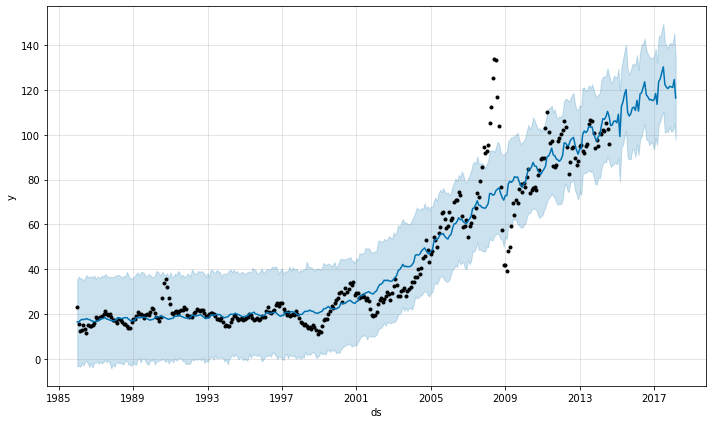

In [151]:
#initial visualization of model results
model_visualization = model.plot(forecast)

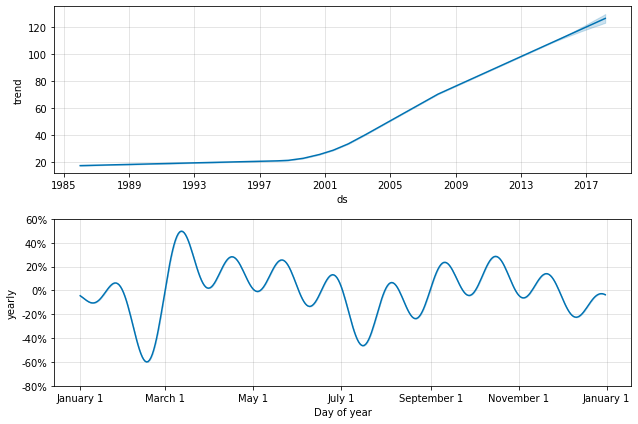

In [152]:
# plotting forecast components
forecast_components = model.plot_components(forecast)

In [156]:
#comparing initial projections to test data
df_crossval = cross_validation(m, initial='1825 days', period='180 days', horizon = '365 days')
df_crossval.head()

df_mtrcs = performance_metrics(df_crossval)
df_mtrcs.head()

INFO:prophet:Making 46 forecasts with cutoffs between 1991-05-29 00:00:00 and 2013-08-01 00:00:00


  0%|          | 0/46 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,194.124404,13.932853,8.912530,0.195224,0.140781,0.184257,0.709091
1,38 days,183.474429,13.545273,8.498529,0.192509,0.140625,0.180941,0.727273
2,39 days,183.303187,13.538951,8.471709,0.191087,0.140228,0.179308,0.727273
3,40 days,187.064246,13.677143,8.747561,0.198180,0.140781,0.184938,0.727273
4,41 days,188.075568,13.714065,8.837116,0.201431,0.142300,0.188719,0.709091
